In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import pydicom
from skimage.io import imread

from unet3d_res import *

sys.path.append("../")
from metrics import *
sys.path.append("../../")
from preprocess_helpers import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load Trained Model

In [2]:
MODEL_NAME = 'unet_lidc.hdf5'

model = unet3d_res()
model.load_weights(MODEL_NAME)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Load Data

In [3]:
X_train, Y_train = [], []
for im in os.listdir('data/train/image0'):
    x = np.array([
        imread(f'data/train/image{i}/{im}')
        for i in range(8)
    ]).reshape(256, 256, 8, 1)
    X_train.append(x/255)
    
    y = np.array([
        imread(f'data/train/label{i}/{im}')
        for i in range(8)
    ]).reshape(256, 256, 8, 1)
    Y_train.append(y)
X_train = np.array(X_train)
Y_train = np.array(Y_train)


X_test, Y_test = [], []
for im in os.listdir('data/test/image0'):
    x = np.array([
        imread(f'data/test/image{i}/{im}')
        for i in range(8)
    ]).reshape(256, 256, 8, 1)
    X_test.append(x/255)
    
    y = np.array([
        imread(f'data/test/label{i}/{im}')
        for i in range(8)
    ]).reshape(256, 256, 8, 1)
    Y_test.append(y)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(314, 256, 256, 8, 1)
(314, 256, 256, 8, 1)
(91, 256, 256, 8, 1)
(91, 256, 256, 8, 1)


# ROI Metric 

*(Different from 2D metric in metrics.py)*

In [7]:
def get_most_activated_roi(y_pred_mask):
    y_pred_mask = y_pred_mask.reshape(256, 256, 8)
    blobs = y_pred_mask > .05
    blobs_labels = measure.label(blobs, background=0)
    labels = np.unique(blobs_labels)[1:]
    activations = []
    for label in labels:
        blob_activation = 0
        idxs = np.argwhere(blobs_labels==label)
        for idx_x, idx_y, idx_z in idxs: 
            blob_activation += y_pred_mask[idx_x][idx_y][idx_z]
        activations.append(blob_activation/len(idxs))
    max_region = np.argwhere(blobs_labels == np.argmax(activations) + 1).T
    x_center = int(max_region[0].mean())
    y_center = int(max_region[1].mean())
    return [(x_center-16, y_center-16, 0), (x_center+16, y_center+16, 8)]

def get_grouped_nodule_coords(y_true_mask):
    y_true_mask = y_true_mask.reshape(256, 256, 8)
    blobs = y_true_mask == 1
    blobs_labels = measure.label(blobs, background=0)
    labels = np.unique(blobs_labels)[1:]
    return [np.argwhere(blobs_labels == l) for l in labels]

def percent_included(y_true, y_pred):
    if np.count_nonzero(np.round(y_pred)) == 0:
        return 0
    predicted_roi = get_most_activated_roi(y_pred)
    mask_groups_coords = get_grouped_nodule_coords(y_true)
    
    xmin, ymin, zmin = predicted_roi[0]
    xmax, ymax, zmax = predicted_roi[1]
    
    percentages = []
    for coords in mask_groups_coords:
        count = 0
        for xi, yi, zi in coords:
            if xi >= xmin and xi < xmax and yi >= ymin and yi < ymax:
                count += 1
        percentages.append(count/len(coords))
    return max(percentages)

# Predict

### Train example

276


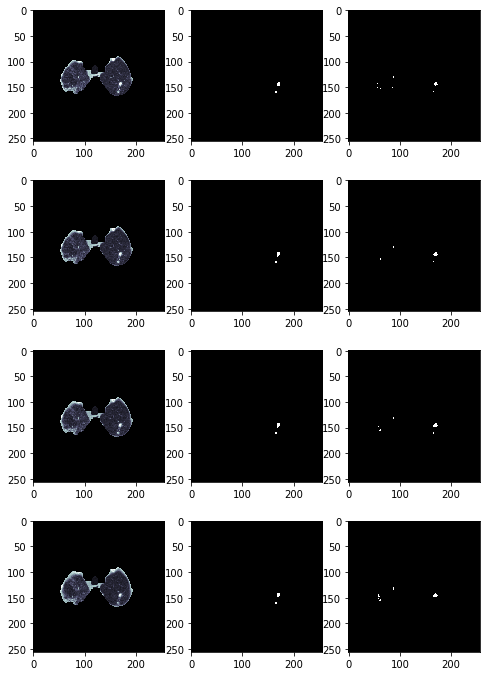

Recall 0.7694300518134715
Precision 0.48848684210526316
Dice coefficient 0.5979899497487438
Percent included in ROI 1.0


In [8]:
idx = np.random.randint(len(os.listdir('data/train/image0')))
print(idx)

y_hat = model.predict(X_train[[idx]])
thresh = y_hat.max()/2
y_hat[y_hat >= thresh] = 1
y_hat[y_hat < thresh] = 0

fig, axs = plt.subplots(4, 3, figsize=(8, 12))
for i in range(4, 8):
    axs[i-4][0].imshow(X_train[idx].reshape(8, 256, 256)[i], cmap='bone')
    axs[i-4][1].imshow(Y_train[idx].reshape(8, 256, 256)[i], cmap='bone')
    axs[i-4][2].imshow(y_hat.reshape(8, 256, 256)[i], cmap='bone')

plt.show()

print(f"Recall {image_recall(Y_train[idx], y_hat[0])}")
print(f"Precision {image_precision(Y_train[idx], y_hat[0])}")
print(f"Dice coefficient {dice_coef(Y_train[idx], y_hat[0])}")
print(f"Percent included in ROI {percent_included(Y_train[idx], y_hat[0])}")

### Test example

36


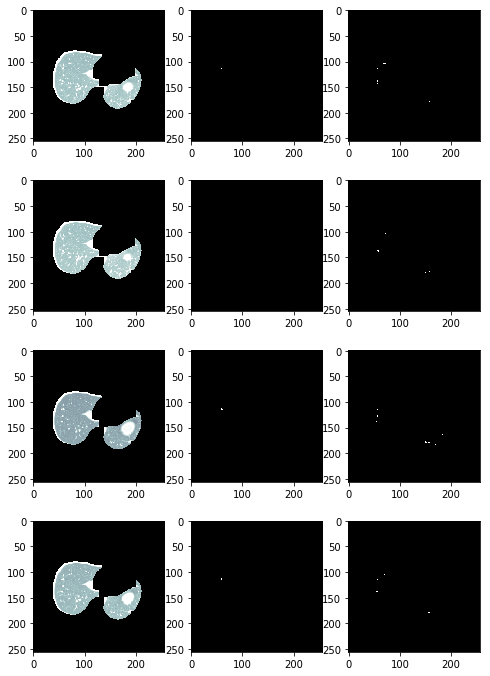

Recall 0.07999999821186066
Precision 0.015564202331006527
Dice coefficient 0.02922077922077922
Percent included in ROI 0.0


In [101]:
idx = np.random.randint(len(os.listdir('data/test/image0')))
print(idx)

y_hat = model.predict(X_test[[idx]])
thresh = y_hat.max()/2
y_hat[y_hat >= thresh] = 1
y_hat[y_hat < thresh] = 0

fig, axs = plt.subplots(4, 3, figsize=(8, 12))
for i in range(2, 6):
    axs[i-4][0].imshow(X_test[idx].reshape(8, 256, 256)[i], cmap='bone')
    axs[i-4][1].imshow(Y_test[idx].reshape(8, 256, 256)[i], cmap='bone')
    axs[i-4][2].imshow(y_hat.reshape(8, 256, 256)[i], cmap='bone')

plt.show()

print(f"Recall {image_recall(Y_test[idx], y_hat[0])}")
print(f"Precision {image_precision(Y_test[idx], y_hat[0])}")
print(f"Dice coefficient {dice_coef(Y_test[idx], y_hat[0])}")
print(f"Percent included in ROI {percent_included(Y_test[idx], y_hat[0])}")

### Train Overall

In [95]:
# train_recall = []
# train_precision = []
# train_dice = []
# train_percent_included = []

# for i in range(len(X_train)):
#     sys.stdout.write(f'\r{i}')
#     y_hat = model.predict(X_train[[i]])
#     train_recall.append(image_recall(Y_train[i], y_hat[0]))
#     train_precision.append(image_precision(Y_train[i], y_hat[0]))
#     train_dice.append(dice_coef(Y_train[i], y_hat[0]))
#     train_percent_included.append(percent_included(Y_train[i], y_hat[0]))

train_recall = np.array(train_recall)
train_precision = np.array(train_precision)
train_precision = train_precision[np.logical_not(np.isnan(train_precision))]
train_dice = np.array(train_dice)
train_percent_included = np.array(train_percent_included)

print()
print(np.array(f"Training set average recall: {train_recall.mean()}"))
print(np.array(f"Training set average precision: {train_precision.mean()}"))
print(np.array(f"Training set average dice coefficient: {train_dice.mean()}"))
print(np.array(f"Training set average percent included in ROI: {train_percent_included.mean()}"))


Training set average recall: nan
Training set average precision: 0.45068517327308655
Training set average dice coefficient: 0.4897510335778037
Training set average percent included in ROI: 0.7913043478260869


### Test Overall

In [10]:
test_recall = []
test_precision = []
test_dice = []
test_percent_included = []

for i in range(len(X_test)):
    sys.stdout.write(f'\r{i}')
    y_hat = model.predict(X_test[[i]])
    test_recall.append(image_recall(Y_test[i], y_hat[0]))
    test_precision.append(image_precision(Y_test[i], y_hat[0]))
    test_dice.append(dice_coef(Y_test[i], y_hat[0]))
    test_percent_included.append(percent_included(Y_test[i], y_hat[0]))

        
test_recall = np.array(test_recall)
test_precision = np.array(test_precision)
test_precision = test_precision[np.logical_not(np.isnan(test_precision))]
test_dice = np.array(test_dice)
test_percent_included = np.array(test_percent_included)

print()
print(np.array(f"Test set recall: {test_recall.mean()}"))
print(np.array(f"Test set precision: {test_precision.mean()}"))
print(np.array(f"Test set dice coefficient: {test_dice.mean()}"))
print(np.array(f"Test set average percent included in ROI: {test_percent_included.mean()}"))


Test set recall: 0.08845919403291623
Test set precision: 0.1253057869654758
Test set dice coefficient: 0.10008301176796787
Test set average percent included in ROI: 0.6818181818181818
